In [1]:
### IMF DOTS THRESHOLD ANALYSIS

In [2]:
### INITIALIZATION

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import gc

In [3]:
### DEFINING COUNTRY CODES EXTRACTOR

def get_country_codes(use_local_copy = False):  
    ### In case if URL is unavailable:
    if (use_local_copy):
        url_country_code = 'Data_Files/Source_Files/countrycode.html'
    ### Online extraction:
    else:
        url_country_code = 'https://countrycode.org/'
    df_full_codes = pd.read_html(url_country_code, index_col = 'COUNTRY')[0]
    df_full_codes[['ISO SHORT', 'ISO LONG']] = df_full_codes['ISO CODES'].str.split(' / ', expand = True)
    df_result = df_full_codes[['ISO SHORT', 'ISO LONG']].sort_index()    
    df_result.index = df_result.index.str.upper()
    ### Results output:
    return df_result

In [4]:
### DEFINING EXTRACTION UNIVERSE DATA FROM MS EXCEL SOURCE (TO BE IGNORED IN PRODUCT CODE)

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(engine = 'openpyxl', io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                 na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [5]:
### NEED TO BE ADOPTED: COMMON DATA EXTRACTION STEPS

### MultiIndex level slice constant:
All = slice(None)
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Technical Constants:
str_date_end = '2022-10-31'
### World Country Codes:
df_country_codes = get_country_codes()
### ISON membership history:
ser_ison_membership = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_end))
### ISON SHORT IDs list:
list_ison_countries = sorted(list(map(str, ser_ison_membership.index.get_level_values(1).unique())))
### ISON LONG IDs list:
list_ison_long = list(df_country_codes.loc[df_country_codes['ISO SHORT'].isin(ser_ison_membership.index.get_level_values('Country').unique()), 'ISO LONG'].values)
### ISON current status:
ser_ison_status = ser_ison_membership.loc[str_date_end].droplevel('Date')
### ISON stats:
int_ison_number = len(list_ison_long)
list_regions = ['DM', 'EM', 'FM']
dict_ison_len = {}
dict_ison_len['Full Universe'] = int_ison_number
for iter_region in list_regions:
    dict_ison_len[iter_region] = len(ser_ison_status[ser_ison_status == iter_region])
ser_market_len = pd.Series(dict_ison_len)
ser_market_len.index.names = ['Market']    

In [103]:
### IMF DOTS: DATA KEEPING PARAMETERS

### Resulting dataset:
str_path_imf_dots_augmented = 'Data_Files/Source_Files/dots_augmented_unconditional.h5'
str_key_imf_dots_augmented = 'dots_export_augmented'
### Technical Constants:
str_date_end = '2022-10-31'
date_start = pd.Timestamp('1989-12-29')
date_end = pd.Timestamp(str_date_end)
date_ison = pd.Timestamp('1994-12-31')
### Threshold parameters:
int_partners_number = 5
flo_threshold = 0.05
date_demo_first = pd.Timestamp('2020-12-31') # pd.Timestamp('2011-12-30')
date_demo_last = pd.Timestamp('2021-12-31')
int_reporters_number = 10

In [14]:
### IMF DOTS: AUGMENTED DATA LOADING

### Resulting dataset:
ser_dots_export = pd.read_hdf(str_path_imf_dots_augmented, str_key_imf_dots_augmented).astype('float32')

In [40]:
### IMF DOTS: THRESHOLD ANALYSIS PREPARATION

gc.collect()
### Weights calculation:
ser_dots_limited = ser_dots_export.replace({0.0 : np.NaN}).dropna().groupby(['Date', 'Reporter'], group_keys = False)\
                                                                   .apply(lambda ser_group: (ser_group.nlargest(int_partners_number) / ser_group.sum()).round(2))
ser_dots_limited.name = 'Weight'
### First partners difference:
def first_difference(ser_group):
    ser_sorted = ser_group.sort_values(ascending = False)
    if (len(ser_sorted) > 1):
        flo_diff = ser_sorted[0] - ser_sorted[1]
    else:
        flo_diff = 0
    return flo_diff
ser_monopoly = ser_dots_limited.groupby(['Date', 'Reporter']).apply(first_difference)

In [174]:
### TEMP

ser_iter_top
ser_iter_label = ser_iter_top.index.get_level_values('Partner') + ': ' + ser_iter_top.astype(str).str[: -2]
ser_iter_label.name = 'Label'
df_iter_label = ser_iter_label.reset_index()
df_iter_label['Partner_Number'] = df_iter_label.groupby('Reporter').cumcount() + 1
df_to_annot = df_iter_label[['Reporter', 'Partner_Number', 'Label']].set_index(['Reporter', 'Partner_Number']).squeeze().unstack('Partner_Number').sort_index()
df_to_annot

Partner_Number,1,2,3,4,5
Reporter,,,,,
CA,US: 77,CN: n,GB: n,JP: n,MX: n
CL,CN: 40,US: 16,JP: 8,BR: 5,KR: 5
CR,US: 44,NL: 6,GT: 5,BE: 5,MX: n
CY,MH: 37,GR: 8,LR: 7,LB: 6,NL: 5
HK,CN: 60,US: 6,IN: n,TW: n,JP: n
LB,CM: 42,AE: 14,CH: 5,EG: n,IQ: n
MX,US: 82,CA: n,CN: n,KR: n,DE: n
NG,IN: 34,CN: 11,ES: 9,FR: 6,IT: 5
TW,CN: 38,US: 12,HK: 11,SG: 7,JP: 5


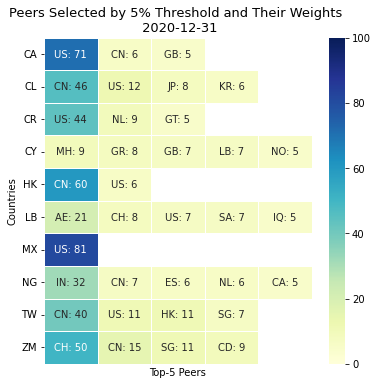

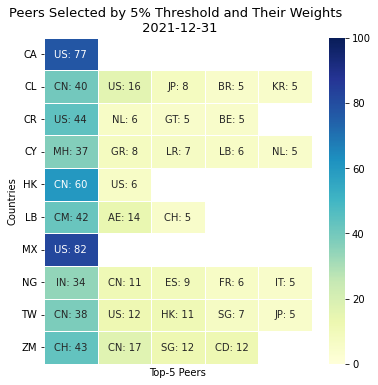

In [176]:
### IMF DOTS: THRESHOLD ANALYSIS

gc.collect()
### Defining reporters with maximal differences:
idx_top_reporters = ser_monopoly.loc[date_demo_last].nlargest(int_reporters_number).index
### Looping over dates:
for iter_date in [date_demo_first, date_demo_last]:
    ### Values preparation:
    ser_iter_top = ser_dots_limited.loc[iter_date, idx_top_reporters].droplevel('Date')
    ser_iter_top.loc[ser_iter_top < flo_threshold] = np.NaN
    ser_iter_top = (ser_iter_top * 100).round(0)
    df_iter_top = ser_iter_top.reset_index()
    df_iter_top['Partner_Number'] = df_iter_top.groupby('Reporter').cumcount() + 1
    df_to_plot = df_iter_top[['Reporter', 'Partner_Number', 'Weight']].set_index(['Reporter', 'Partner_Number']).squeeze().unstack('Partner_Number').sort_index()
    ### Annotations preparation:
    ser_iter_label = ser_iter_top.index.get_level_values('Partner') + ': ' + ser_iter_top.astype(str).str[: -2]
    ser_iter_label.name = 'Label'
    df_iter_label = ser_iter_label.reset_index()
    df_iter_label['Partner_Number'] = df_iter_label.groupby('Reporter').cumcount() + 1
    df_to_annot = df_iter_label[['Reporter', 'Partner_Number', 'Label']].set_index(['Reporter', 'Partner_Number']).squeeze().unstack('Partner_Number').sort_index()
    ### Results plotting:
    plt.figure(figsize = (6, 6))
#    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = False, yticklabels = True, cbar = True, linewidth = 0.5, square = False, 
#                             annot = True, vmin = 0, vmax = 100)
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = False, yticklabels = True, cbar = True, linewidth = 0.5, square = False, 
                             annot = df_to_annot.values, fmt = '', vmin = 0, vmax = 100)    
    ### Plot formatting:
#    ax_heatmap.set(xlabel = 'Top-' + str(int_partners_number) + ' Partner Export Weights', ylabel = 'Countries')    
    ax_heatmap.set(xlabel = 'Top-' + str(int_partners_number) + ' Peers', ylabel = 'Countries')    
    ax_heatmap.set_title('Peers Selected by ' + str(int(flo_threshold * 100)) + '% Threshold and Their Weights \n ' + \
                         iter_date.strftime(format = '%Y-%m-%d'), fontsize = 13)
    plt.yticks(rotation = 0)
    plt.show()      
#    break

In [107]:
### TEMP

display(ser_dots_limited['2020-12-31', 'CA'])
display(ser_dots_limited['2021-12-31', 'CA'])

Partner
US    0.71
CN    0.06
GB    0.05
JP    0.02
NL    0.01
Name: Weight, dtype: float32

Partner
US    0.77
CN    0.04
GB    0.02
JP    0.02
MX    0.01
Name: Weight, dtype: float32

In [ ]:
### IMF CPIS: THRESHOLD SIZE CALСULATION



### Threshold limits options:
list_limits = [0.05, 0.02, 0.01]
### Looping over threshold limits:
for flo_limit in list_limits:
    gc.collect()
    ### Threshold sum for pairs initialization:
    dict_threshold_full = {}
    ### Mean thresholod sum for reporters initialization:
    dict_threshold_mean = {}

    ### Threshold sum calculation:
    ser_threshold_full = ser_cdis_asset.groupby(['Date', 'Reporter']).apply(clip_threshold, flo_limit)
    ser_threshold_mean = ser_threshold_full.unstack('Reporter').resample('BY').mean().stack('Reporter').sort_index()
    ### Mean threshold preparation to plot:
    ser_isoned = ser_threshold_mean.to_frame().join(ser_ison_status).set_index('Market', append = True).squeeze()
    ser_isoned = (ser_isoned * 100).astype(int)
    ### Looping over regions:
    for iter_region in list_regions:
        ### Dataset formatting:
        df_to_plot = ser_isoned.loc[:, :, iter_region].reset_index()
        df_to_plot['Year'] = df_to_plot['Date'].dt.year
        df_to_plot = df_to_plot.drop(['Date'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
        ### Results plotting:
        plt.figure(figsize = (15, 7))
        ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True,
                                 vmin = 0, vmax = ser_isoned.max())
        ### Plot formatting:
        ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
        ax_heatmap.set_title('Direct Investment' + ': Proportion of Volume Removed by ' + str(int(flo_limit * 100)) + '% threshold (' + iter_region + ')',
                             fontsize = 15)
        plt.yticks(rotation = 0)
        plt.show()  
#        break        